# Plume paths

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

import pandas as pd
import seaborn as sns

from vast_2017_mc2 import source_file_pickle

%matplotlib inline
sns.set_style()

## Reload

In [2]:
def reload():
    data = pd.read_pickle(str(source_file_pickle))
    globals().update(data)
    print('loaded: {}'.format(', '.join(data.keys())))
reload()

loaded: all_joined, sensor, wind, locations, subperiods


## Plume paths

In [93]:
def rows_as_series(df):
    for ndx in range(len(df)):
        yield df.iloc[ndx, ]

def get_final_plume_shapes():
    def get_subperiod_fine_displacements(subperiod):
        wind_angles = sp.interpolate.interp1d(x=wind.index.values.astype(float), y=np.unwrap(np.deg2rad(wind['direction'].values)), kind='linear')
        wind_speed = sp.interpolate.interp1d(x=wind.index.values.astype(float), y=wind['speed'].values, kind='linear')
        result = pd.DataFrame(index=pd.date_range(start=subperiod['start'], end=subperiod['end'], freq='min'))
        result.index.name = 'emission_time'
        result['subperiod'] = subperiod['index']
        float_timesteps = result.index.values.astype(float)
        speed = wind_speed(float_timesteps)
        angle = wind_angles(float_timesteps)
        result['emission_wind_speed'] = speed
        interval_seconds = (result.index.shift(1) - result.index).total_seconds().values
        for col, trig_func in [('east_km', np.sin), ('north_km', np.cos)]:
            # cumulative displacement in km
            result[col] = np.flipud(np.cumsum(np.r_[0, np.flipud(- speed * trig_func(angle) * interval_seconds / 1000 )[1:]]))
        return result
    return pd.concat(map(get_subperiod_fine_displacements, rows_as_series(subperiods[subperiods['has_wind_data']].reset_index())))
    
final_plume_shapes = get_final_plume_shapes()
final_plume_shapes.head(2)

,subperiod,emission_wind_speed,east_km,north_km
emission_time,,,,
2016-04-01 00:00:00,1,4.000000,2328.522616,-1095.425925
2016-04-01 00:01:00,1,4.005556,2328.478879,-1095.661906


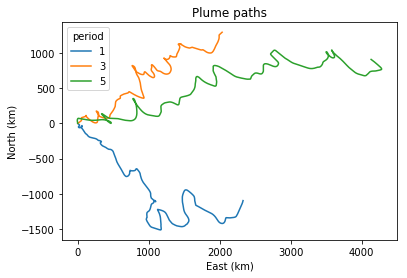

In [4]:
plt.figure()
period_indices = fine_displacements['subperiod'].unique()
for p in period_indices:
    to_plot = fine_displacements[fine_displacements['subperiod'] == p]
    plt.plot(to_plot['east_km'].values, to_plot['north_km'].values, label=p)
plt.legend(title='period')
plt.title('Plume paths')
plt.xlabel('East (km)')
plt.ylabel('North (km)')
plt.show()

In [8]:
len(fine_displacements)

126543

## Diffusion

In [78]:
def get_highest_concentration_diffusion_rates():
    def partial_concentrations(diffusion_rate, distance_sq, age):
        return np.exp(-distance_sq / (2 * diffusion_rate * diffusion_rate * age)) / (diffusion_rate * np.sqrt(2 * np.pi * age))
    def highest_concentration_diffusion_rate(distance_sq, age):
        valid = (distance_sq > 0) & (age > 0)
        distance_sq = distance_sq[valid]
        age = age[valid]
        standalone_rate = np.sqrt(distance_sq/age)
        ndx_highest_standalone = np.argmax(partial_concentrations(standalone_rate, distance_sq, age))
        def negative_total_concentration(diffusion_rate):
            return - partial_concentrations(diffusion_rate, distance_sq, age).sum()
        minimized = sp.optimize.minimize(negative_total_concentration, standalone_rate[ndx_highest_standalone])
        return minimized.x[0] if minimized.success else np.nan
    periods = subperiods[subperiods['has_wind_data']].index.values
    factory_locations = locations[locations['type'] == 'factory']
    sensor_locations = locations[locations['type'] == 'sensor']
    coord_cols = ['east_km', 'north_km']
    max_plume_distance = 50
    # direction * sensor * factory
    sensor_factory_displacements = np.expand_dims(sensor_locations[coord_cols].values.T,2) - np.expand_dims(factory_locations[coord_cols].values.T, 1)
    component_dfs = []
    for period in periods:
        period_fine_displacements = fine_displacements[fine_displacements['subperiod'] == period]
        period_emission_seconds = (lambda x: (x-x[0]).total_seconds().values)(period_fine_displacements.index)
        period_fine_displacement_coords = period_fine_displacements[coord_cols].values
        measurement_times = all_joined[all_joined['subperiod'] == period].index.get_level_values('timestamp').unique().sort_values()
        measurement_rows = np.searchsorted(period_fine_displacements.index, measurement_times)
        assert all(period_fine_displacements.index.values[measurement_rows] == measurement_times.values)
        diff_rates = []
        for measurement_row, measurement_time in zip(measurement_rows, measurement_times):
            plume_displacements = period_fine_displacement_coords[measurement_row].reshape(1,-1)- period_fine_displacement_coords[:measurement_row,:]
            plume_distance = np.sqrt((plume_displacements*plume_displacements).sum(axis=1))
            within_range = plume_distance < max_plume_distance
            plume_age_seconds = period_emission_seconds[measurement_row] - period_emission_seconds[:measurement_row]
            plume_displacements = plume_displacements[within_range, ...]
            plume_age_seconds = plume_age_seconds[within_range]
            sensor_distance_components = np.reshape(plume_displacements.T, (2,1,1,-1)) - np.expand_dims(sensor_factory_displacements, 3)
            sensor_squared_distances = (sensor_distance_components*sensor_distance_components).sum(axis=0)
            diff_rates.append(np.apply_along_axis(highest_concentration_diffusion_rate, -1, sensor_squared_distances, age=plume_age_seconds))
        diff_rates = np.array(diff_rates).transpose(1,2,0) # sensor * facory * timestep
        partial_result = pd.DataFrame(index=pd.Index(measurement_times, name='timestamp'))
        for sensor, sensor_rates in zip(rows_as_series(sensor_locations), diff_rates):
            for factory, factory_rates in zip(rows_as_series(factory_locations), sensor_rates):
                partial_result[(sensor['name'], factory['name'])] = factory_rates
        component_dfs.append(partial_result)
    result = pd.concat(component_dfs)
    result.columns = pd.MultiIndex.from_tuples(result.columns, names=['sensor', 'factory'])
    return result
highest_concentration_diffusion_rates = get_highest_concentration_diffusion_rates()
highest_concentration_diffusion_rates.head(2)

In [88]:
highest_concentration_diffusion_rates.head()

sensor                                           1                          \
factory             Roadrunner Fitness Electronics Kasios Office Furniture   
timestamp                                                                    
2016-04-01 01:00:00                       0.160913                0.178133   
2016-04-01 02:00:00                       0.199025                0.215402   
2016-04-01 03:00:00                       0.233361                0.249995   
2016-04-01 04:00:00                       0.236390                0.253775   
2016-04-01 05:00:00                       0.236395                0.254219   

sensor                                                    \
factory             Radiance ColourTek Indigo Sol Boards   
timestamp                                                  
2016-04-01 01:00:00           0.200888          0.229008   
2016-04-01 02:00:00           0.233371          0.255591   
2016-04-01 03:00:00           0.267065          0.287708   
2016-04-01 04:00:00           0.271833          0.292973   
2016-04-01 05:00:00           0.273298          0.295076   

sensor                                           2                          \
factory             Roadrunner Fitness Electronics Kasios Office Furniture   
timestamp                                                                    
2016-04-01 01:00:00                       0.191675                0.212317   
2016-04-01 02:00:00                       0.229058                0.248487   
2016-04-01 03:00:00                       0.264564                0.283952   
2016-04-01 04:00:00                       0.268830                0.288940   
2016-04-01 05:00:00                       0.269415                0.289964   

sensor                                                    \
factory             Radiance ColourTek Indigo Sol Boards   
timestamp                                                  
2016-04-01 01:00:00           0.227073          0.253940   
2016-04-01 02:00:00           0.258582          0.279697   
2016-04-01 03:00:00           0.292236          0.311806   
2016-04-01 04:00:00           0.297616          0.317663   
2016-04-01 05:00:00           0.299351          0.320005   

sensor                                           3                          \
factory             Roadrunner Fitness Electronics Kasios Office Furniture   
timestamp                                                                    
2016-04-01 01:00:00                       0.197886                0.221709   
2016-04-01 02:00:00                       0.237190                0.259144   
2016-04-01 03:00:00                       0.274748                0.296062   
2016-04-01 04:00:00                       0.279398                0.301492   
2016-04-01 05:00:00                       0.279895                0.302496   

sensor                     ...                         7                    \
factory                    ...        Radiance ColourTek Indigo Sol Boards   
timestamp                  ...                                               
2016-04-01 01:00:00        ...                  0.108685          0.140868   
2016-04-01 02:00:00        ...                  0.148806          0.179693   
2016-04-01 03:00:00        ...                  0.184934          0.214567   
2016-04-01 04:00:00        ...                  0.183510          0.217029   
2016-04-01 05:00:00        ...                  0.180627          0.216684   

sensor                                           8                          \
factory             Roadrunner Fitness Electronics Kasios Office Furniture   
timestamp                                                                    
2016-04-01 01:00:00                       0.101062                0.116176   
2016-04-01 02:00:00                       0.141592                0.154721   
2016-04-01 03:00:00                       0.177256                0.188049   
2016-04-01 04:00:00                       0.172907                0.18

In [89]:
len(highest_concentration_diffusion_rates)

2105

In [91]:
highest_concentration_diffusion_rates.describe().T

count      mean       std       min  \
sensor factory                                                                
1      Roadrunner Fitness Electronics  2023.0  0.142943  0.054783  0.002192   
       Kasios Office Furniture         2022.0  0.140657  0.055283  0.006496   
       Radiance ColourTek              2049.0  0.155383  0.060516  0.009024   
       Indigo Sol Boards               2050.0  0.160421  0.064353  0.006524   
2      Roadrunner Fitness Electronics  2016.0  0.134981  0.057724  0.002612   
       Kasios Office Furniture         2017.0  0.139728  0.061408  0.002867   
       Radiance ColourTek              2037.0  0.150167  0.063302  0.001244   
       Indigo Sol Boards               2044.0  0.156700  0.068264  0.005814   
3      Roadrunner Fitness Electronics  2007.0  0.136021  0.058568  0.005937   
       Kasios Office Furniture         2008.0  0.146482  0.062825  0.006738   
       Radiance ColourTek              2035.0  0.145374  0.063576  0.004873   
       Indigo Sol Boards               2023.0  0.153765  0.067999  0.005159   
4      Roadrunner Fitness Electronics  2020.0  0.153546  0.059151  0.003240   
       Kasios Office Furniture         2020.0  0.163026  0.062721  0.007582   
       Radiance ColourTek              2018.0  0.143734  0.063963  0.001583   
       Indigo Sol Boards               2042.0  0.150064  0.068064  0.000872   
5      Roadrunner Fitness Electronics  2031.0  0.174622  0.062885  0.003936   
       Kasios Office Furniture         2043.0  0.179142  0.065296  0.006144   
       Radiance ColourTek              2015.0  0.145749  0.058918  0.006715   
       Indigo Sol Boards               2016.0  0.147178  0.063828  0.002658   
6      Roadrunner Fitness Electronics  2019.0  0.160385  0.060465  0.005725   
       Kasios Office Furniture         2023.0  0.157753  0.058429  0.008179   
       Radiance ColourTek              1968.0  0.119451  0.050913  0.002532   
       Indigo Sol Boards               1991.0  0.130785  0.051195  0.003687   
7      Roadrunner Fitness Electronics  2022.0  0.157246  0.069369  0.000712   
       Kasios Office Furniture         2007.0  0.148048  0.063713  0.001405   
       Radiance ColourTek              2026.0  0.152596  0.063786  0.010061   
       Indigo Sol Boards               2043.0  0.153619  0.060813  0.001430   
8      Roadrunner Fitness Electronics  2018.0  0.148017  0.062154  0.005445   
       Kasios Office Furniture         1996.0  0.141971  0.057041  0.004895   
       Radiance ColourTek              2043.0  0.155690  0.060975  0.005705   
       Indigo Sol Boards               2036.0  0.159514  0.060849  0.008995   
9      Roadrunner Fitness Electronics  2060.0  0.199502  0.071781  0.008100   
       Kasios Office Furniture         2062.0  0.201436  0.072558  0.004859   
       Radiance ColourTek              2037.0  0.167419  0.060765  0.005354   
       Indigo Sol Boards               2026.0  0.157119  0.060322  0.007011   

                                            25%       50%       75%       max  
sensor factory                                                                 
1      Roadrunner Fitness Electronics  0.103677  0.143969  0.183490  0.325444  
       Kasios Office Furniture         0.100409  0.140162  0.178895  0.334557  
       Radiance ColourTek              0.114407  0.151817  0.194868  0.383952  
       Indigo Sol Boards               0.118019  0.155333  0.199063  0.414435  
2      Roadrunner Fitness Electronics  0.094164  0.136128  0.171163  0.330592  
       Kasios Office Furniture         0.097617  0.138837  0.176425  0.344584  
       Radiance ColourTek              0.109532  0.147490  0.183675  0.387761  
       Indigo Sol Boards               0.114658  0.152146  0.189810  0.419183  
3      Roadrunner Fitness Electronics  0.093485  0.137374  0.175484  0.314161  
       Kasios Office Furniture         0.100085  0.147224  0.188669  0.332137  
       Radiance ColourTek              0.104248  0.142446  0.180570  0.370437